In [6]:
from tensorflow import keras
import tensorflow as tf
import qkeras
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import sklearn.metrics as metrics
import pandas as pd

In [13]:
%run Utility.ipynb

In [3]:
# Load EMNIST character dataset
signal = 9 # I
background = 12 # L

ds, ds_info = tfds.load('emnist/letters', split=['train', 'test'], with_info=True)

df_train = tfds.as_dataframe(ds[0])
df_train = df_train[df_train['label'].isin([signal,background])]
df_test = tfds.as_dataframe(ds[1])
df_test = df_test[df_test['label'].isin([signal,background])]

df_train['image'] = df_train['image'].apply(lambda im: tf.image.flip_left_right(tf.image.rot90(im, 3)))
df_train['label'] = df_train['label'].apply(lambda x: 1 if x == signal else 0)
df_test['image'] = df_test['image'].apply(lambda im: tf.image.flip_left_right(tf.image.rot90(im, 3)))
df_test['label'] = df_test['label'].apply(lambda x: 1 if x == signal else 0)

train_images = np.stack(df_train['image'].to_numpy()) / 255
train_labels = df_train['label'].to_numpy()
test_images = np.stack(df_test['image'].to_numpy()) / 255
test_labels = df_test['label'].to_numpy()

# Generate smaller testing sample for csim and co-sim
test_images_sample = np.concatenate([test_images[np.where(test_labels == 1)[0][:100]], test_images[np.where(test_labels == 0)[0][:100]]])
test_labels_sample = np.concatenate([np.ones(100), np.zeros(100)]) 

1


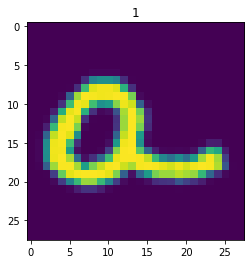

2


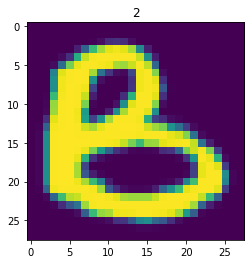

3


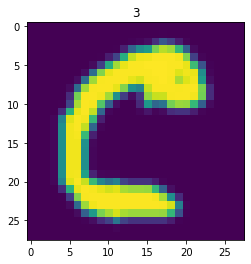

4


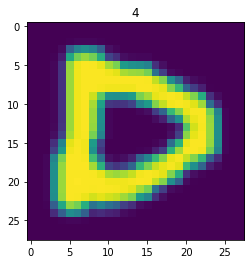

5


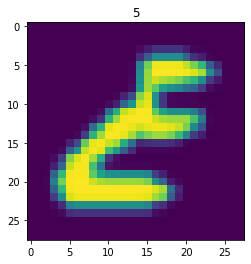

6


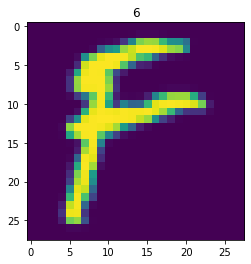

7


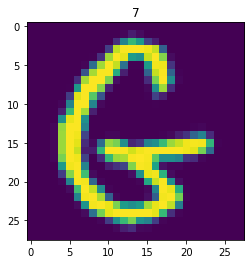

8


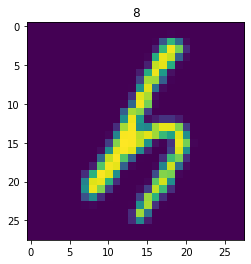

9


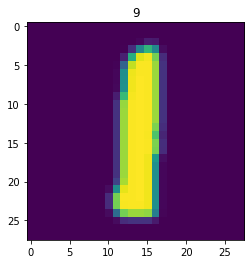

10


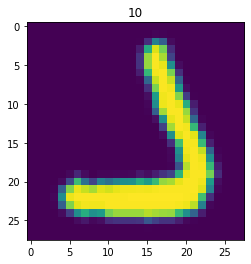

11


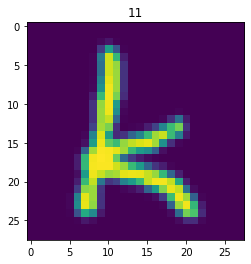

12


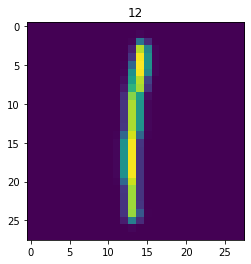

13


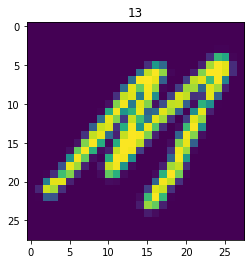

14


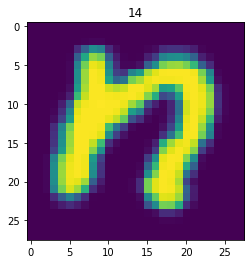

15


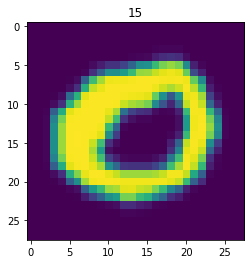

16


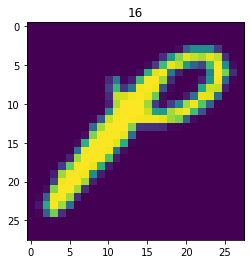

17


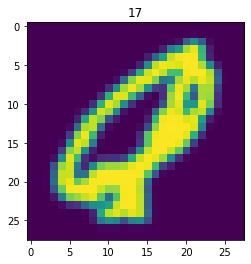

18


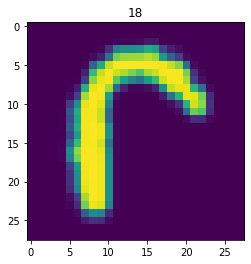

19


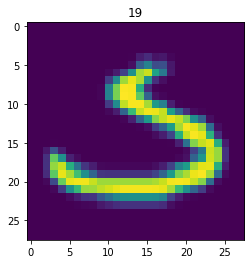

In [58]:
# EMNIST character options
df = tfds.as_dataframe(ds[1])
for label in sorted(df['label'].unique()):
    print(label)
    im = df[df['label'] == label]['image'].iloc[0]
    plt.imshow(tf.image.flip_left_right(tf.image.rot90(im, 3)))
    plt.title(label)
    plt.show()

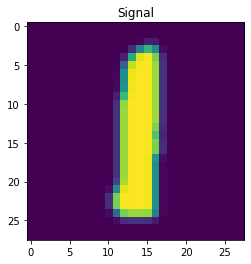

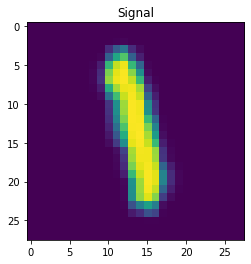

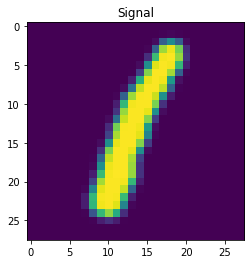

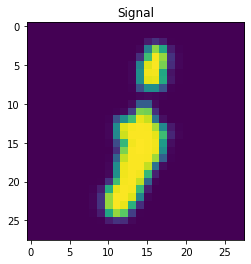

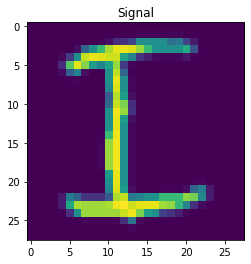

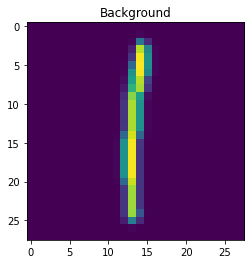

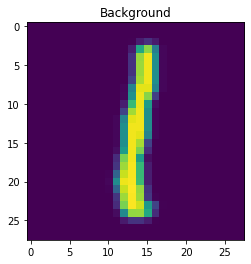

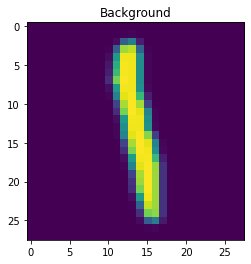

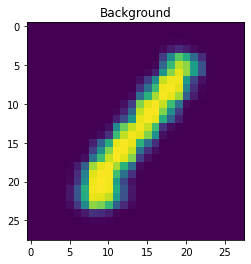

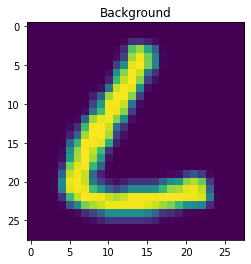

In [6]:
# Plot Signal vs Background
for im in test_images[np.where(test_labels == 1)[0]][:5]:
    plt.imshow(im)
    plt.title('Signal')
    plt.show()
    
for im in test_images[np.where(test_labels == 0)[0]][:5]:
    plt.imshow(im)
    plt.title('Background')
    plt.show()

In [4]:
# Baseline Model
baseline = keras.models.Sequential(name='Baseline')
baseline.add(keras.layers.Input((28,28,1), name='ImgInput'))
baseline.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_0'))
baseline.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
baseline.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_1'))
baseline.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
baseline.add(keras.layers.Flatten())
baseline.add(keras.layers.Dense(8, activation='relu', name='Dense_0'))
baseline.add(keras.layers.Dense(1, activation='sigmoid', name='Output'))
baseline = train_best_auc(baseline, train_images, train_labels, test_images, test_labels)

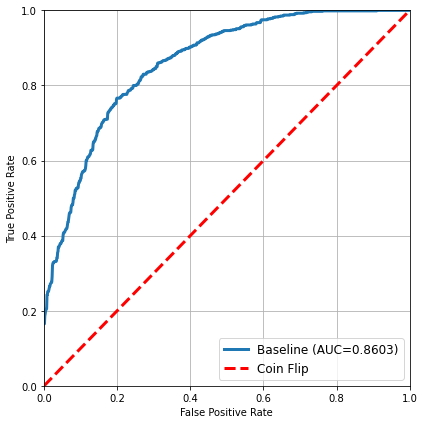

In [14]:
# Control Model ROC
roc(baseline, test_images, test_labels)

Interpreting Sequential
Topology:
Layer name: ImgInput, layer type: InputLayer, current shape: [[None, 28, 28, 1]]
Layer name: Conv2D_0, layer type: Conv2D, current shape: [[None, 28, 28, 1]]
Layer name: MaxPooling_0, layer type: MaxPooling2D, current shape: [[None, 26, 26, 4]]
Layer name: Conv2D_1, layer type: Conv2D, current shape: [[None, 13, 13, 4]]
Layer name: MaxPooling_1, layer type: MaxPooling2D, current shape: [[None, 11, 11, 4]]
Layer name: Dense_0, layer type: Dense, current shape: [[None, 5, 5, 4]]
Layer name: Output, layer type: Dense, current shape: [[None, 8]]
Creating HLS model
Writing HLS project
Done
Profiling weights
Profiling activations
   Conv2D_0
   MaxPooling_0
   Conv2D_1
   MaxPooling_1
   flatten
   Dense_0
   Output


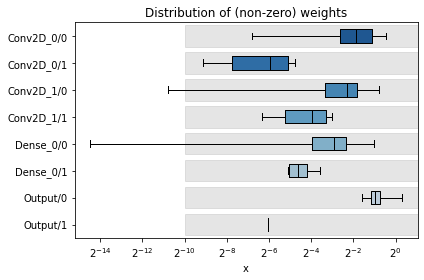

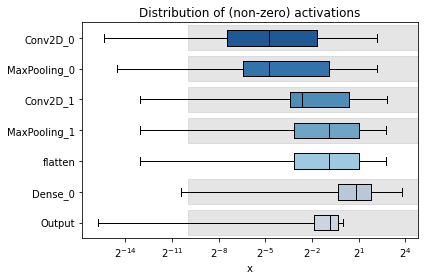

In [17]:
# Convert baseline model -- io_parallel
r = synthesize_model(baseline, 'io_parallel', 'ap_fixed<16,6>', 'Resource', 
                     show_quantization_plots=True, test_input=test_images_sample)

In [18]:
# Baseline model io_parallel synthesis results
print('Latency Clock Cycles')
display(pd.DataFrame().append(r['syn_latency_estimates'], ignore_index=True))
print('Area Estimates')
display(pd.DataFrame().append(r['reports']['syn_xml']['profile']['AreaEstimates']['Resources'], ignore_index=True))

Latency Clock Cycles


,avg,best,worst
0,24930,24530,24932


Area Estimates


,BRAM_18K,DSP48E,FF,LUT,URAM
0,192,96,69634,89629,0


In [16]:
# Quantized Models
quantized_levels = [
    ['quantized_bits(15,5)', 'quantized_relu(15,5)', 'quantized_bits_16_6'],
    ['quantized_bits(8,4)', 'quantized_relu(8,4)', 'quantized_bits_9_5']
]

q_models = []
for q_level in quantized_levels:
    q = keras.models.Sequential(name=q_level[2])
    q.add(keras.layers.Input((28,28,1), name='ImgInput'))
    q.add(qkeras.QConv2D(4, (3,3), kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Conv2D_0'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_0'))
    q.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
    q.add(qkeras.QConv2D(4, (3,3), kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Conv2D_1'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_1'))
    q.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
    q.add(keras.layers.Flatten())
    q.add(qkeras.QDense(8, kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Dense_0'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_2'))
    q.add(qkeras.QDense(1, kernel_quantizer=q_level[0], bias_quantizer=q_level[0], activation='sigmoid', name='Output'))
    q = train_best_auc(q, train_images, train_labels, test_images, test_labels)
    q_models.append(q)

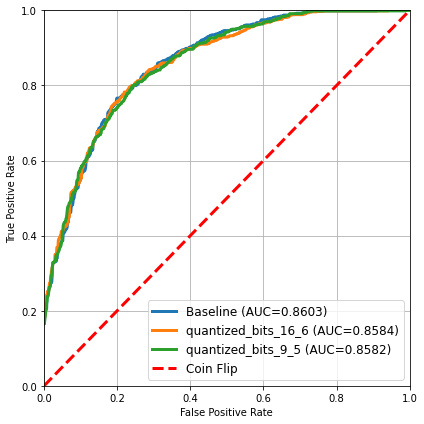

In [21]:
# Quantized Model Comparison
roc([baseline] + q_models, test_images, test_labels)

In [18]:
# TWN Model
twn = keras.models.Sequential(name='TernaryWeights')
twn.add(keras.layers.Input((28,28,1), name='ImgInput'))
twn.add(qkeras.QConv2D(4, (3,3), kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_bits(8,4)', activation='quantized_relu(8,4)', name='Conv2D_0'))
twn.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
twn.add(qkeras.QConv2D(4, (3,3), kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_bits(8,4)', activation='quantized_relu(8,4)', name='Conv2D_1'))
twn.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
twn.add(keras.layers.Flatten())
twn.add(qkeras.QDense(8, kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_relu(8,4)', activation='quantized_relu(8,4)', name='Dense_0'))
twn.add(qkeras.QDense(1, kernel_quantizer='quantized_relu(8,4)', bias_quantizer='quantized_relu(8,4)', activation='smooth_sigmoid', name='Output'))
twn = train_best_auc(twn, train_images, train_labels, test_images, test_labels)

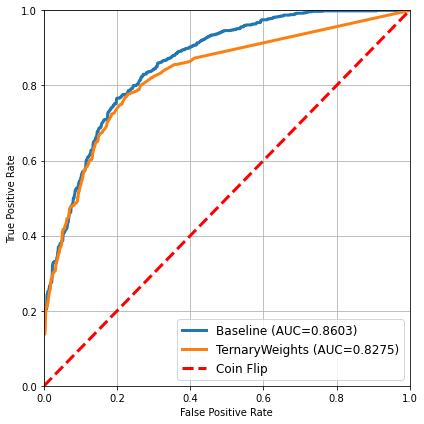

In [19]:
# TWN Model ROC
roc([baseline, twn], test_images, test_labels)

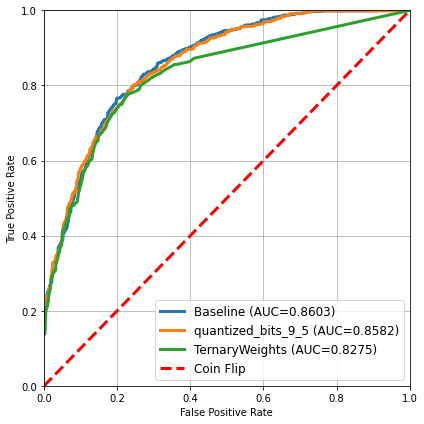

In [22]:
# Quantized ROC for presentation
roc([baseline, q_models[-1], twn], test_images, test_labels)

In [39]:
# Quantized Deployment Model
q_export = keras.models.Sequential(name='QExport')
q_export.add(keras.layers.Input((28,28,1), name='ImgInput'))
q_export.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_0'))
q_export.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
q_export.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_1'))
q_export.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
q_export.add(keras.layers.Flatten(name='Flatten'))
q_export.add(keras.layers.Dense(8, activation='relu', name='Dense_0'))
q_export.add(keras.layers.Dense(1, activation='sigmoid', name='Output'))

r = qkeras.utils.model_save_quantized_weights(q_models[1])

for layer, weights in r.items():
    q_export.get_layer(layer).set_weights(weights['weights'])

... quantizing model


In [40]:
q_models[1].predict(test_images_sample)

array([[7.21154451e-01],
       [8.17720115e-01],
       [6.62687302e-01],
       [9.96475697e-01],
       [9.99223709e-01],
       [6.74157739e-01],
       [4.04154658e-01],
       [9.90324259e-01],
       [9.99870181e-01],
       [7.68733203e-01],
       [8.53424788e-01],
       [5.28168380e-01],
       [3.63195062e-01],
       [9.95859981e-01],
       [9.94607210e-01],
       [9.95123148e-01],
       [3.03835094e-01],
       [7.61449814e-01],
       [8.12421262e-01],
       [9.31056201e-01],
       [4.24769878e-01],
       [2.18169272e-01],
       [9.87035871e-01],
       [6.44896269e-01],
       [7.67428517e-01],
       [4.54714298e-01],
       [8.79094958e-01],
       [8.80334973e-01],
       [8.35550666e-01],
       [8.68604064e-01],
       [6.57648325e-01],
       [4.98291016e-01],
       [7.90206730e-01],
       [9.20718431e-01],
       [9.25802231e-01],
       [7.01099455e-01],
       [6.90872014e-01],
       [7.18890548e-01],
       [8.11825275e-01],
       [9.78631079e-01],


In [41]:
q_export.predict(test_images_sample)

array([[7.3108375e-01],
       [8.2555687e-01],
       [6.6634530e-01],
       [9.9665868e-01],
       [9.9920708e-01],
       [6.9704664e-01],
       [3.9367682e-01],
       [9.9119675e-01],
       [9.9986136e-01],
       [7.6928937e-01],
       [8.4559327e-01],
       [5.4396927e-01],
       [3.5893777e-01],
       [9.9591410e-01],
       [9.9447918e-01],
       [9.9523228e-01],
       [3.1347167e-01],
       [7.6230061e-01],
       [8.1451285e-01],
       [9.3370199e-01],
       [4.4479722e-01],
       [2.1567956e-01],
       [9.8739076e-01],
       [6.2637019e-01],
       [7.7669871e-01],
       [4.5993513e-01],
       [8.9591658e-01],
       [8.7647277e-01],
       [8.3804047e-01],
       [8.6771953e-01],
       [6.7063648e-01],
       [4.8342827e-01],
       [8.0497038e-01],
       [9.2085588e-01],
       [9.1782796e-01],
       [7.2309291e-01],
       [6.4051580e-01],
       [7.1292412e-01],
       [8.1338149e-01],
       [9.8150635e-01],
       [4.6051034e-01],
       [8.103902

Interpreting Sequential
Topology:
Layer name: ImgInput, layer type: InputLayer, current shape: [[None, 28, 28, 1]]
Layer name: Conv2D_0, layer type: Conv2D, current shape: [[None, 28, 28, 1]]
Layer name: MaxPooling_0, layer type: MaxPooling2D, current shape: [[None, 26, 26, 4]]
Layer name: Conv2D_1, layer type: Conv2D, current shape: [[None, 13, 13, 4]]
Layer name: MaxPooling_1, layer type: MaxPooling2D, current shape: [[None, 11, 11, 4]]
Layer name: Dense_0, layer type: Dense, current shape: [[None, 5, 5, 4]]
Layer name: Output, layer type: Dense, current shape: [[None, 8]]
Creating HLS model
Writing HLS project
Done
Profiling weights
Profiling activations
   Conv2D_0
   MaxPooling_0
   Conv2D_1
   MaxPooling_1
   Flatten
   Dense_0
   Output


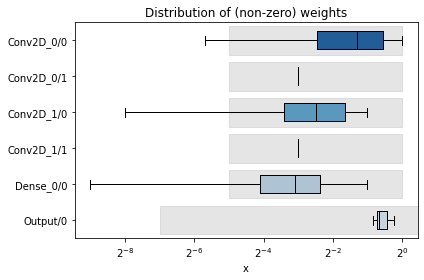

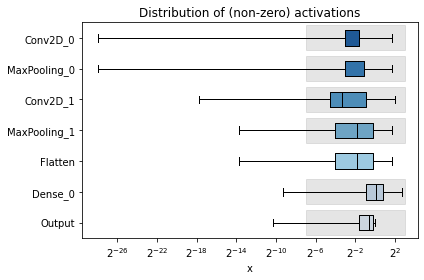

--------------------------------------------------
QExport CSIM Metrics
binary accuracy = 0.78
AUC = 0.8596999999999999
--------------------------------------------------
--------------------------------------------------
QExport CO-SIM Metrics
binary accuracy = 0.78
AUC = 0.8596999999999999
--------------------------------------------------


In [44]:
# Synthesize Quantized Model
r = synthesize_model(q_export, 'io_stream', 'ap_fixed<11,4>', 'Latency', csim=True, synth=True, cosim=True, validate_sim_results=True,
                     show_quantization_plots=True, test_input=test_images_sample, test_truth=test_labels_sample,
                     cfg_file='ConfigFiles/q_export.yml')

In [47]:
# Quantized model io_stream synthesis results
print('Latency Clock Cycles')
display(pd.DataFrame().append(r['syn_latency_estimates'], ignore_index=True))
print('Simulation Results')
display(pd.DataFrame().append(r['reports']['sim_rpt'], ignore_index=True))
print('Area Estimates')
display(pd.DataFrame().append(r['reports']['syn_xml']['profile']['AreaEstimates']['Resources'], ignore_index=True))

Latency Clock Cycles


,avg,best,worst
0,1596,1596,1596


Simulation Results


,AVER_LATENCY,AVER_THROUGHPUT,MAX_LATENCY,MAX_THROUGHPUT,MIN_LATENCY,MIN_THROUGHPUT
0,1580.0,1576.0,1580.0,1576.0,1580.0,1576.0


Area Estimates


,BRAM_18K,DSP48E,FF,LUT,URAM
0,30,422,25117,47726,0
